# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Clash Royale Predictions** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions

In [41]:
import hopsworks
import datetime
import pandas as pd
from xgboost import Booster, DMatrix  # Import DMatrix for predictions
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import json
import os
import requests

with open('../data/hopsworks-api-key.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
project = hopsworks.login()
fs = project.get_feature_store() 

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="clash_royale_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()
saved_model_dir

2025-01-08 21:00:31,009 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 21:00:31,017 INFO: Initializing external client
2025-01-08 21:00:31,017 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 21:00:32,429 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1175700


'C:\\Users\\steve\\AppData\\Local\\Temp\\be6e9838-82d4-4356-8d99-e97acb757dc5\\clash_royale_xgboost_model/1'

In [42]:
# Connect to Hopsworks
project = hopsworks.login()
fs = project.get_feature_store()

# Load the clash_royale_onehotencoding dataset
feature_group = fs.get_feature_group(name="clash_royale_onehotencoding", version=5)
data = feature_group.read()

# Model path
MODEL_PATH = "clash_royale_model/model.json"

# Function to load the XGBoost model
def load_model(model_path):
    """Load the XGBoost model."""
    model = Booster()
    model.load_model(model_path)
    return model

# Load the model
model = load_model(MODEL_PATH)

# Function to make predictions
def predict_outcome(deck1, deck2):
    """Make a prediction based on the selected decks."""
    # Concatenate features
    combined_features = np.concatenate((deck1, deck2)).reshape(1, -1)

    # Convert to DMatrix
    dmatrix = DMatrix(combined_features)

    # Prediction
    prediction = model.predict(dmatrix)

    return prediction[0] * 100

# Main function for predictions
def main():
    print("Clash Royale Match Predictions")
    print("Predicting the outcomes for the last 30 matches...\n")

    # Select the last 30 rows of the dataset
    last_30_matches = data.tail(30)

    predictions = []
    for index, row in last_30_matches.iterrows():
        player1 = row["player1"]
        player2 = row["player2"]
        deck1 = np.array(row["deck1"])
        deck2 = np.array(row["deck2"])

        # Predict the outcome
        prediction = predict_outcome(deck1, deck2)

        # Store the result
        predictions.append({
            "Player 1": player1,
            "Player 2": player2,
            "Player 1 Win Probability (%)": prediction
        })

    # Display the predictions
    for match in predictions:
        print(f"Player 1 ({match['Player 1']}) vs Player 2 ({match['Player 2']})")
        print(f"Probability of Player 1 winning: {match['Player 1 Win Probability (%)']:.2f}%\n")

if __name__ == "__main__":
    main()


2025-01-08 21:00:35,266 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 21:00:35,272 INFO: Initializing external client
2025-01-08 21:00:35,273 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 21:00:36,658 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1175700
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.71s) 
Clash Royale Match Predictions
Predicting the outcomes for the last 30 matches...

Player 1 (Diwel26) vs Player 2 (stef)
Probability of Player 1 winning: 48.46%

Player 1 (Diwel26) vs Player 2 (sirop de fraise)
Probability of Player 1 winning: 47.08%

Player 1 (Diwel26) vs Player 2 (diego)
Probability of Player 1 winning: 49.07%

Player 1 (Diwel26) vs Player 2 (papillon d'or)
Probability of Player 1 winning: 48.52%

Player 1 (Diwel26) vs Player 2 (felix)
Probability of Player 1 winning: 53.21%

Player 1 (Diwel26) vs Player 2 (Пельмень)
Pr

In [43]:
import os

# Create the directory if it doesn't exist
os.makedirs("../data", exist_ok=True)


In [44]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import Booster, DMatrix

# File path to store predictions
PREDICTIONS_FILE = "/data/clash_royale_predictions.json"

# Function to load the XGBoost model
def load_model(model_path):
    """Load the XGBoost model."""
    model = Booster()
    model.load_model(model_path)
    return model

# Function to make predictions
def predict_outcome(deck1, deck2, model):
    """Make a prediction based on the selected decks."""
    # Concatenate features
    combined_features = np.concatenate((deck1, deck2)).reshape(1, -1)

    # Convert to DMatrix
    dmatrix = DMatrix(combined_features)

    # Prediction
    prediction = model.predict(dmatrix)

    return prediction[0] * 100

# Function to load existing predictions
def load_predictions(file_path):
    """Load predictions from a file."""
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return json.load(f)
    return []

# Function to save predictions
def save_predictions(predictions, file_path):
    """Save predictions to a file."""
    with open(file_path, "w") as f:
        json.dump(predictions, f, indent=4)

# Function to create and save the chart
def create_and_save_chart(predictions, file_path):
    # Extract data for visualization
    player1_names = [match["Player 1"] for match in predictions]
    player2_names = [match["Player 2"] for match in predictions]
    win_percentages = [match["Player 1 Win Probability (%)"] for match in predictions]
    lose_percentages = [100 - win for win in win_percentages]

    # Plot settings
    fig, ax = plt.subplots(figsize=(10, len(predictions)))

    # Plot bars
    bar_width = 0.8
    y_pos = np.arange(len(predictions))
    ax.barh(y_pos, win_percentages, color='blue', edgecolor='black', label='Player 1 Win %', height=bar_width)
    ax.barh(y_pos, lose_percentages, left=win_percentages, color='red', edgecolor='black', label='Player 2 Win %', height=bar_width)

    # Add player names
    for i, (p1, p2, wp) in enumerate(zip(player1_names, player2_names, win_percentages)):
        ax.text(-5, i, p1, va='center', ha='right', fontsize=10, color='black')  # Player 1 on the left
        ax.text(105, i, p2, va='center', ha='left', fontsize=10, color='black')  # Player 2 on the right

    # Customize plot
    ax.set_xlim(0, 100)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([])
    ax.set_xlabel('Winning Probability (%)')
    ax.set_title('Match Predictions: Winning Probabilities')
    ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Save the figure as PNG
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

# Main function
def main():
    print("Clash Royale Match Predictions")
    print("Predicting the outcomes for the last 30 matches...\n")

    # Connect to Hopsworks
    project = hopsworks.login()
    fs = project.get_feature_store()

    # Load the clash_royale_onehotencoding dataset
    feature_group = fs.get_feature_group(name="clash_royale_onehotencoding", version=5)
    data = feature_group.read()

    # Load the model
    MODEL_PATH = "clash_royale_model/model.json"
    model = load_model(MODEL_PATH)

    # Select the last 30 rows of the dataset
    last_30_matches = data.tail(30)

    # Load existing predictions
    predictions = load_predictions(PREDICTIONS_FILE)

    # Generate predictions for the last 30 matches
    for index, row in last_30_matches.iterrows():
        player1 = row["player1"]
        player2 = row["player2"]
        deck1 = np.array(row["deck1"])
        deck2 = np.array(row["deck2"])

        # Predict the outcome
        prediction = predict_outcome(deck1, deck2, model)

        # Store the result
        predictions.append({
            "Player 1": player1,
            "Player 2": player2,
            "Player 1 Win Probability (%)": prediction
        })

    # Save updated predictions
    save_predictions(predictions, PREDICTIONS_FILE)

    # Create and save the updated chart
    create_and_save_chart(predictions, "/data/clash_royale_updated_predictions.png")

if __name__ == "__main__":
    main()


Clash Royale Match Predictions
Predicting the outcomes for the last 30 matches...

2025-01-08 21:00:40,542 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-08 21:00:40,548 INFO: Initializing external client
2025-01-08 21:00:40,549 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 21:00:41,920 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1175700
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.74s) 


FileNotFoundError: [Errno 2] No such file or directory: '/data/clash_royale_predictions.json'

Clash Royale Match Predictions
Predicting the outcomes for the last 30 matches...

2025-01-08 20:54:39,184 INFO: Closing external client and cleaning up certificates.


Connection closed.
2025-01-08 20:54:39,193 INFO: Initializing external client
2025-01-08 20:54:39,194 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-08 20:54:40,590 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1175700
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


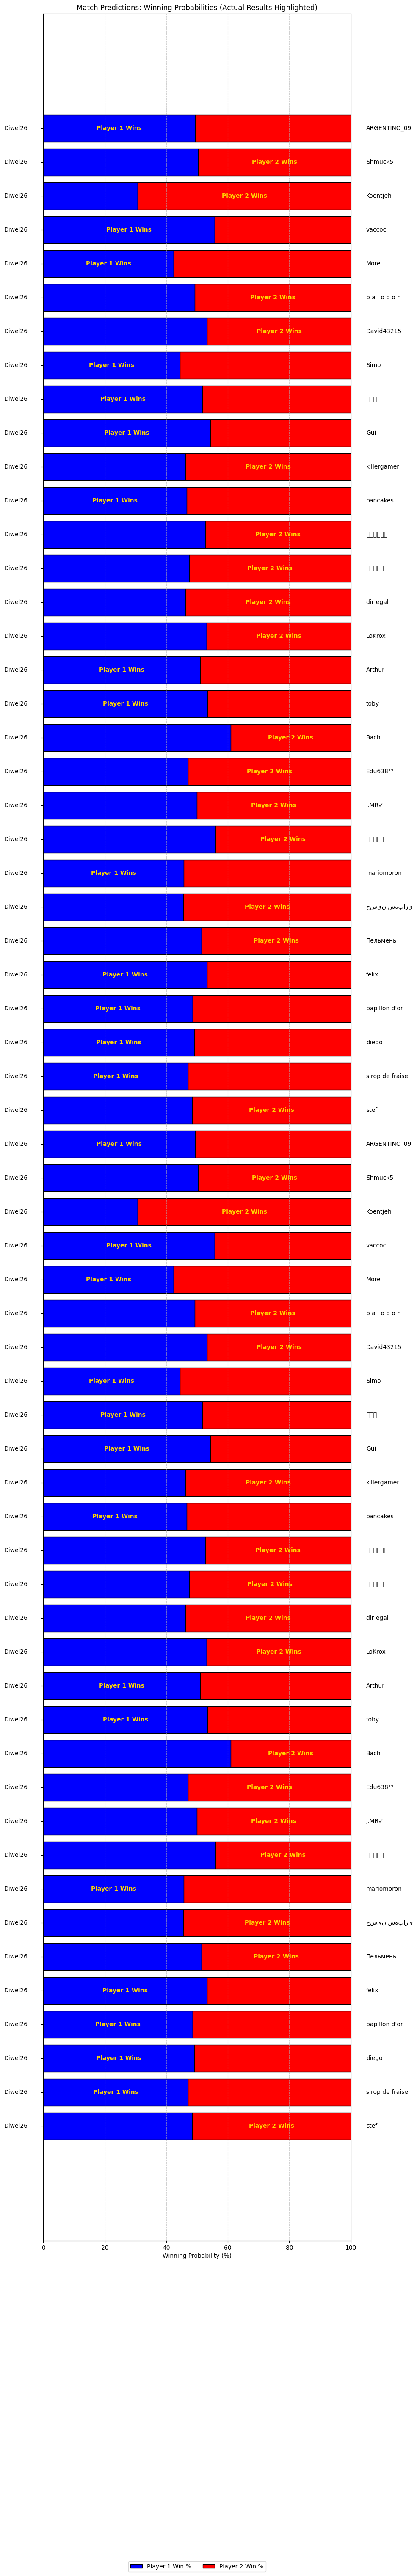

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from xgboost import Booster, DMatrix
import hopsworks

# Directory to save files
SAVE_DIR = "./data"
os.makedirs(SAVE_DIR, exist_ok=True)

# File paths
PREDICTIONS_FILE = os.path.join(SAVE_DIR, "clash_royale_predictions.json")
CHART_FILE = os.path.join(SAVE_DIR, "clash_royale_updated_predictions.png")

# Function to load the XGBoost model
def load_model(model_path):
    """Load the XGBoost model."""
    model = Booster()
    model.load_model(model_path)
    return model

# Function to make predictions
def predict_outcome(deck1, deck2, model):
    """Make a prediction based on the selected decks."""
    # Concatenate features
    combined_features = np.concatenate((deck1, deck2)).reshape(1, -1)

    # Convert to DMatrix
    dmatrix = DMatrix(combined_features)

    # Prediction
    prediction = model.predict(dmatrix)

    return prediction[0] * 100

# Function to load existing predictions
def load_predictions(file_path):
    """Load predictions from a file."""
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return json.load(f)
    return []

# Function to save predictions
def save_predictions(predictions, file_path):
    """Save predictions to a file."""
    with open(file_path, "w") as f:
        json.dump(predictions, f, indent=4)

# Function to create and save the chart
def create_and_save_chart(predictions, file_path):
    # Extract data for visualization
    player1_names = [match["Player 1"] for match in predictions]
    player2_names = [match["Player 2"] for match in predictions]
    win_percentages = [match["Player 1 Win Probability (%)"] for match in predictions]
    lose_percentages = [100 - win for win in win_percentages]
    actual_results = [match["Actual Result"] for match in predictions]

    # Plot settings
    fig, ax = plt.subplots(figsize=(10, len(predictions)))

    # Plot bars
    bar_width = 0.8
    y_pos = np.arange(len(predictions))
    ax.barh(y_pos, win_percentages, color='blue', edgecolor='black', label='Player 1 Win %', height=bar_width)
    ax.barh(y_pos, lose_percentages, left=win_percentages, color='red', edgecolor='black', label='Player 2 Win %', height=bar_width)

    # Add player names and highlight actual results
    for i, (p1, p2, wp, ar) in enumerate(zip(player1_names, player2_names, win_percentages, actual_results)):
        ax.text(-5, i, p1, va='center', ha='right', fontsize=10, color='black')  # Player 1 on the left
        ax.text(105, i, p2, va='center', ha='left', fontsize=10, color='black')  # Player 2 on the right
        
        # Highlight actual results in gold
        if ar == 1:  # Player 1 won
            ax.text(wp / 2, i, "Player 1 Wins", color='gold', weight='bold', ha='center', va='center')
        else:  # Player 2 won
            ax.text(wp + (100 - wp) / 2, i, "Player 2 Wins", color='gold', weight='bold', ha='center', va='center')

    # Customize plot
    ax.set_xlim(0, 100)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([])
    ax.set_xlabel('Winning Probability (%)')
    ax.set_title('Match Predictions: Winning Probabilities (Actual Results Highlighted)')
    ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.15))
    ax.grid(axis='x', linestyle='--', alpha=0.6)

    # Save the figure as PNG
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

# Main function
def main():
    print("Clash Royale Match Predictions")
    print("Predicting the outcomes for the last 30 matches...\n")

    # Connect to Hopsworks
    project = hopsworks.login()
    fs = project.get_feature_store()

    # Load the clash_royale_onehotencoding dataset
    feature_group = fs.get_feature_group(name="clash_royale_onehotencoding", version=5)
    data = feature_group.read()

    # Load the model
    MODEL_PATH = "clash_royale_model/model.json"
    model = load_model(MODEL_PATH)

    # Select the last 30 rows of the dataset
    last_30_matches = data.tail(30)

    # Load existing predictions
    predictions = load_predictions(PREDICTIONS_FILE)

    # Generate predictions for the last 30 matches
    for index, row in last_30_matches.iterrows():
        player1 = row["player1"]
        player2 = row["player2"]
        deck1 = np.array(row["deck1"])
        deck2 = np.array(row["deck2"])
        actual_result = row["result"]  # Assuming 1 for Player 1 win, 0 for Player 2 win

        # Predict the outcome
        prediction = predict_outcome(deck1, deck2, model)

        # Store the result
        predictions.append({
            "Player 1": player1,
            "Player 2": player2,
            "Player 1 Win Probability (%)": prediction,
            "Actual Result": actual_result  # Store the actual result
        })



    # Save updated predictions
    save_predictions(predictions, PREDICTIONS_FILE)

    # Create and save the updated chart
    create_and_save_chart(predictions, CHART_FILE)

    

if __name__ == "__main__":
    main()


In [40]:
# Directory inside the repository to save the chart
#REPO_DIR = "./clash_royale_repo"  # Path to your repository directory
#os.makedirs(REPO_DIR, exist_ok=True)

# File paths
#PREDICTIONS_FILE = os.path.join(REPO_DIR, "clash_royale_predictions.json")
#CHART_FILE = os.path.join(REPO_DIR, "clash_royale_updated_predictions.png")

# The rest of the code remains the same...
# Save predictions
#save_predictions(predictions, PREDICTIONS_FILE)

# Create and save the updated chart
#create_and_save_chart(predictions, CHART_FILE)

NameError: name 'predictions' is not defined